<a href="https://colab.research.google.com/github/nithish19k/Pattern-recognition/blob/main/Copy_of_Nithish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook we will do following tasks:
1. Implement the HON+LBP, VON+LBP, and MON+LBP approaches for a single image
2. Practice these features and visualize them for single image.
3. Implement batch models for these features
4. Load a sample dataset
5. Pre-process the dataset
6. Extract the features into python lists files and store them into CSV with labels.
7. Develop training pipeline for models and feed feature CSVs into them.
8. Train the models with sufficient callbacks and chosen architectures.
9. Evaluate the models



## Implementing the HON-LBP, VON-LBP, and MON-LBP for single image

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def get_pixel(img, center, x, y):
  new_value = 0
  try:
    if img[x][y] >= center:
      new_value = 1
  except:
    pass
  return new_value

def compute_LBP_and_orthogonal_features(image):
    '''

    Input : an Image of suitable size but height = width
    Output: LBP features, HON-LBP features, VON-LBP features, MON-LBP features

    '''
    lbp_image = np.zeros_like(image)
    horizontal_orthogonal_image = np.zeros_like(image)
    vertical_orthogonal_image = np.zeros_like(image)
    fused = np.zeros_like(image)

    height, width = image.shape

    for y in range(0, height):
        for x in range(0, width):
            center = image[y, x]

            # Compute LBP
            val_ar = []
            # top_left
            val_ar.append(get_pixel(image, center, y-1, x-1))
            # top
            val_ar.append(get_pixel(image, center, y-1, x))
            # top_right
            val_ar.append(get_pixel(image, center, y-1, x + 1))
            # right
            val_ar.append(get_pixel(image, center, y, x + 1))
            # bottom_right
            val_ar.append(get_pixel(image, center, y + 1, x + 1))
            # bottom
            val_ar.append(get_pixel(image, center, y + 1, x))
            # bottom_left
            val_ar.append(get_pixel(image, center, y + 1, x-1))
            # left
            val_ar.append(get_pixel(image, center, y, x-1))
            # Now, we need to convert binary
            # values to decimal
            power_val = [1, 2, 4, 8, 16, 32, 64, 128]
            val = 0
            for i in range(len(val_ar)):
              val += val_ar[i] * power_val[7-i]
            lbp_image[y, x] = val

            # Compute Horizontal Orthogonal Features
            horizontal_orthogonal_pattern = 0
            power_val = 7
            for dx in [-2, -1, 1, 2]:
                try:
                  if image[y-2, x + dx] >= center:
                    horizontal_orthogonal_pattern += 2 ** power_val
                except:
                  pass
                power_val -= 1
            for dx in [-2, -1, 1, 2]:
                try:
                  if image[y+2, x + dx] >= center:
                    horizontal_orthogonal_pattern += 2 ** power_val
                except:
                  pass
                power_val -= 1
            # Orthogonalised values OR with LBP values
            horizontal_orthogonal_image[y, x] = np.bitwise_or(horizontal_orthogonal_pattern,val)

            # Compute Vertical Orthogonal Features
            vertical_orthogonal_pattern = 0
            power_val = 7
            for dy in [-2, -1, 1, 2]:
                try:
                  if image[y + dy, x-2] >= center:
                    vertical_orthogonal_pattern += 2 ** power_val
                except:
                  pass
                power_val -= 1
            for dy in [-2, -1, 1, 2]:
                try:
                  if image[y + dy, x+2] >= center:
                    vertical_orthogonal_pattern += 2 ** power_val
                except:
                  pass
                power_val -= 1
            # Orthogonalised values OR with LBP values
            vertical_orthogonal_image[y, x] = np.bitwise_or(vertical_orthogonal_pattern, val)

            # AND between both orthogonal neighbors and OR with LBP
            fused[y, x] = np.bitwise_and(val, np.bitwise_or(horizontal_orthogonal_pattern,vertical_orthogonal_pattern))
    return lbp_image, horizontal_orthogonal_image, vertical_orthogonal_image, fused

In [ ]:
def max_pooling(image, pool_size):
    '''

    Test function for max_pooling the images
    Input : Image of any suitable size
    Output: Image with half dimensions (max pooled)

    '''
    # Get the dimensions of the input image
    height, width = image.shape

    # Calculate the output dimensions after pooling
    output_height = height // pool_size
    output_width = width // pool_size

    # Initialize the pooled image
    pooled_image = np.zeros((output_height, output_width))

    # Iterate over each pooling region
    for i in range(output_height):
        for j in range(output_width):
            # Extract the current pooling region
            pool_region = image[i * pool_size:(i + 1) * pool_size, j * pool_size:(j + 1) * pool_size]
            # Get the maximum value from the pooling region
            max_value = np.average(pool_region)
            # Store the maximum value in the pooled image
            pooled_image[i, j] = max_value

    return pooled_image

## Visualize features for single image

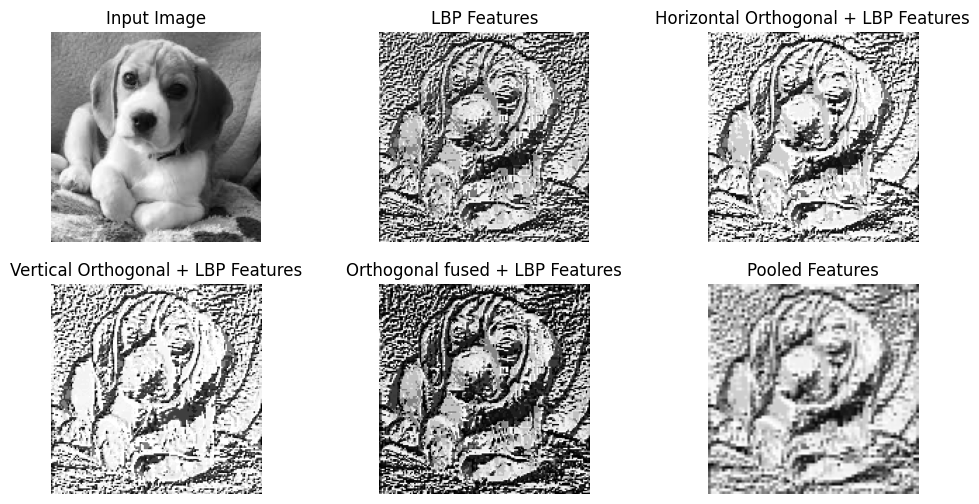

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (replace 'image.jpg' with the path to your image)
image_path = '/content/images.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (150,150))

# Compute features
lbp_features, horizontal_orthogonal_features, vertical_orthogonal_features, fused = compute_LBP_and_orthogonal_features(image)
lbp_pooled = max_pooling(horizontal_orthogonal_features,2)

# Display input image and computed features
plt.figure(figsize=(12, 6))

# Input image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# LBP features
plt.subplot(2, 3, 2)
plt.imshow(lbp_features, cmap='gray')
plt.title('LBP Features')
plt.axis('off')

# Horizontal Orthogonal Neighbor +LBP
plt.subplot(2, 3, 3)
plt.imshow(horizontal_orthogonal_features, cmap='gray')
plt.title('Horizontal Orthogonal + LBP Features')
plt.axis('off')

# Vertical Orthogonal Neighbor +LBP
plt.subplot(2, 3, 4)
plt.imshow(vertical_orthogonal_features, cmap='gray')
plt.title('Vertical Orthogonal + LBP Features')
plt.axis('off')

# Multiplied orthogonal Neighbor +LBP
plt.subplot(2, 3, 5)
plt.imshow(fused, cmap='gray')
plt.title('Orthogonal fused + LBP Features')
plt.axis('off')

# Pooled LBP Features
plt.subplot(2, 3, 6)
plt.imshow(lbp_pooled, cmap='gray')
plt.title('Pooled Features')
plt.axis('off')

plt.show()

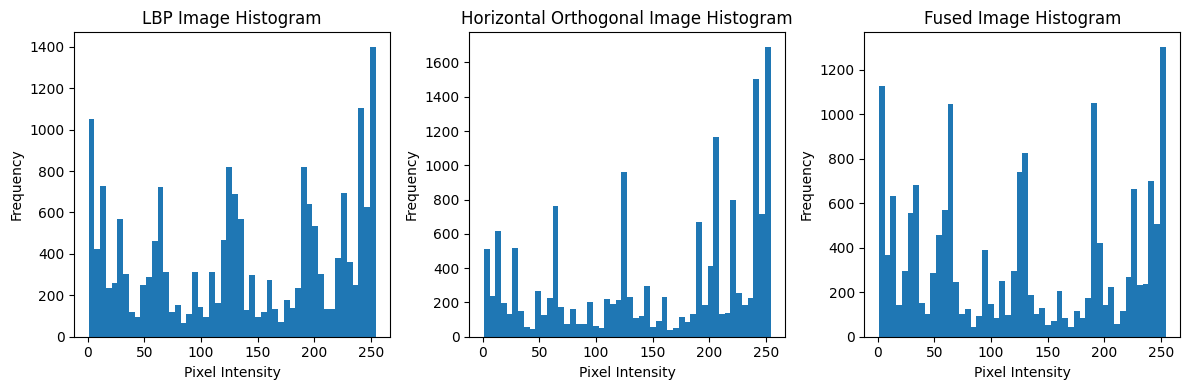

In [ ]:
# Plot histograms
plt.figure(figsize=(12, 4))

# LBP Image Histogram
plt.subplot(1, 3, 1)
plt.hist(lbp_features.ravel(), bins=50, range=(1, 254))
plt.title('LBP Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# HON-LBP Image Histogram
plt.subplot(1, 3, 2)
plt.hist(horizontal_orthogonal_features.ravel(), bins=50, range=(1, 254))
plt.title('Horizontal Orthogonal Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# MON-LBP Image Histogram
plt.subplot(1, 3, 3)
plt.hist(fused.ravel(), bins=50, range=(1, 254))
plt.title('Fused Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Implement batch versions of feature extraction functions

In [ ]:
import numpy as np

def get_pixel(img, center, x, y):
  new_value = 0
  try:
    if img[x][y] >= center:
      new_value = 1
  except:
    pass
  return new_value

def compute_LBP_and_orthogonal_features(image_batch):
    # lets write the code for a batch
    lbp_image_batch = np.zeros((len(image_batch), 120, 120, 1))
    honlbp_image_batch = np.zeros((len(image_batch), 120, 120, 1))
    vonlbp_image_batch = np.zeros((len(image_batch), 120, 120, 1))
    honlbp_image_batch = np.zeros((len(image_batch), 120, 120, 1))
    monlbp_image_batch = np.zeros((len(image_batch), 120, 120, 1))
    for i in range(len(image_batch)):
        image = np.reshape(image_batch[i,:,:,:], (180,180,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (120,120))
        lbp_image = np.zeros_like(image)
        horizontal_orthogonal_image = np.zeros_like(image)
        vertical_orthogonal_image = np.zeros_like(image)
        fused = np.zeros_like(image)

        height, width = image.shape

        for y in range(0, height):
            for x in range(0, width):
                center = image[y, x]

                # Compute LBP
                val_ar = []
                # top_left
                val_ar.append(get_pixel(image, center, y-1, x-1))
                # top
                val_ar.append(get_pixel(image, center, y-1, x))
                # top_right
                val_ar.append(get_pixel(image, center, y-1, x + 1))
                # right
                val_ar.append(get_pixel(image, center, y, x + 1))
                # bottom_right
                val_ar.append(get_pixel(image, center, y + 1, x + 1))
                # bottom
                val_ar.append(get_pixel(image, center, y + 1, x))
                # bottom_left
                val_ar.append(get_pixel(image, center, y + 1, x-1))
                # left
                val_ar.append(get_pixel(image, center, y, x-1))
                # Now, we need to convert binary
                # values to decimal
                power_val = [1, 2, 4, 8, 16, 32, 64, 128]
                val = 0
                for i in range(len(val_ar)):
                  val += val_ar[i] * power_val[7-i]
                lbp_image[y, x] = val

                # Compute Horizontal Orthogonal Features
                horizontal_orthogonal_pattern = 0
                power_val = 7
                for dx in [-2, -1, 1, 2]:
                    try:
                      if image[y-2, x + dx] >= center:
                        horizontal_orthogonal_pattern += 2 ** power_val
                    except:
                      pass
                    power_val -= 1
                for dx in [-2, -1, 1, 2]:
                    try:
                      if image[y+2, x + dx] >= center:
                        horizontal_orthogonal_pattern += 2 ** power_val
                    except:
                      pass
                    power_val -= 1
                # Orthogonalised values AND with LBP values
                horizontal_orthogonal_image[y, x] = np.bitwise_or(horizontal_orthogonal_pattern,val)

                # Compute Vertical Orthogonal Features
                vertical_orthogonal_pattern = 0
                power_val = 7
                for dy in [-2, -1, 1, 2]:
                    try:
                      if image[y + dy, x-2] >= center:
                        vertical_orthogonal_pattern += 2 ** power_val
                    except:
                      pass
                    power_val -= 1
                for dy in [-2, -1, 1, 2]:
                    try:
                      if image[y + dy, x+2] >= center:
                        vertical_orthogonal_pattern += 2 ** power_val
                    except:
                      pass
                    power_val -= 1
                # Orthogonalised values AND with LBP values
                vertical_orthogonal_image[y, x] = np.bitwise_or(vertical_orthogonal_pattern, val)

                # AND between both orthogonal neighbors and OR with LBP
                fused[y, x] = np.bitwise_and(val, np.bitwise_or(horizontal_orthogonal_pattern,vertical_orthogonal_pattern))

                # horizontal_orthogonal_image, vertical_orthogonal_image, fused
        lbp_image_batch[i] = np.reshape(lbp_image,(120,120,1))
        honlbp_image_batch[i] = np.reshape(horizontal_orthogonal_image,(120,120,1))
        vonlbp_image_batch[i] = np.reshape(vertical_orthogonal_image,(120,120,1))
        monlbp_image_batch[i] = np.reshape(fused,(120,120,1))
    #lbp_image = np.reshape(lbp_image, (1,120,120,1))
    return lbp_image_batch.astype(np.float32) / 255.0


## Load the sample dataset

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   118M      0  0:00:06  0:00:06 --:--:--  117M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 IMG_6131-2-2.jpg	   PetImages		        sample_data


In [ ]:
!ls PetImages

Cat  Dog


## Pre-process the dataset

In [ ]:
# Removing the images that are corrupt in this dataset, as the program was crashing agin and again
# This step will ensure smooth operation
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [ ]:
# This step is essential if you are loading the dataset via directory and want to process it via generators
image_size = (120, 120)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=None
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


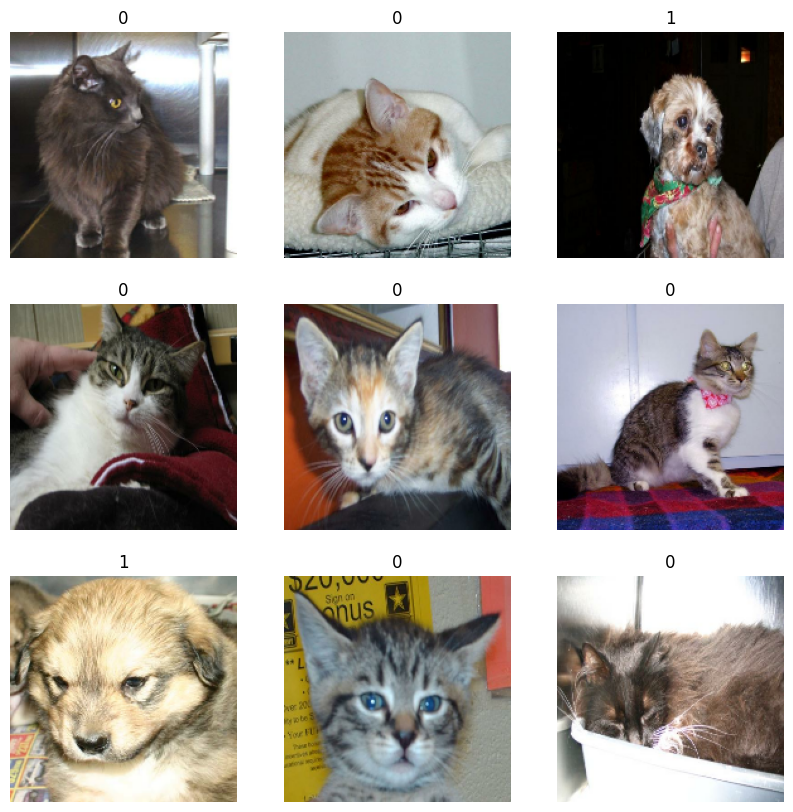

In [ ]:
# Visualising the images an respective labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

## Extract the features into python lists files and store them into CSV with labels

In [ ]:
import pandas as pd
import cv2

# Process Images and Extract Features
lbp_features_list = []
horizontal_features_list = []
vertical_features_list = []
fused_feature_list = []

i=1
for element, label in train_ds:
  if i%1000==0:
    print("1000 done")
  if i%17000==0:
    break
  i+=1
  image = element.numpy()
  label = label.numpy()
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (64,64))
  lbp_features, horizontal_orthogonal_features, vertical_orthogonal_features, fused = compute_LBP_and_orthogonal_features(image)
  lbp_features_list.append(list(lbp_features.flatten()) + [label])
  horizontal_features_list.append(list(horizontal_orthogonal_features.flatten()) + [label])
  vertical_features_list.append(list(vertical_orthogonal_features.flatten()) + [label])
  fused_feature_list.append(list(fused.flatten()) + [label])

1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done


In [ ]:
# Convert feature lists to dataframes
lbp_df = pd.DataFrame(lbp_features_list, columns=[f'LBP_{i}' for i in range(len(lbp_features_list[0])-1)] + ['Class'])
horizontal_df = pd.DataFrame(horizontal_features_list, columns=[f'Horizontal_{i}' for i in range(len(horizontal_features_list[0])-1)] + ['Class'])
vertical_df = pd.DataFrame(vertical_features_list, columns=[f'Vertical_{i}' for i in range(len(vertical_features_list[0])-1)] + ['Class'])
fused_df = pd.DataFrame(fused_feature_list, columns=[f'Fused_{i}' for i in range(len(fused_feature_list[0])-1)] + ['Class'])

In [ ]:
# Making teh CSV files from the dataframes for future loading referenes
# This will also save the running times
lbp_df.to_csv('lbp.csv')
horizontal_df.to_csv('horizontal_df.csv')
vertical_df.to_csv('vertical_df.csv')
fused_df.to_csv('fused_df.csv')

In [ ]:
# Visualizing the image features
plt.figure(figsize=(10, 10))
i=0
for image in horizontal_features_list:
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.array(image[0:14400]).reshape(120,120), cmap='gray')
  plt.title(horizontal_df['Class'][i])
  plt.axis("off")
  i = i+1
  if i==9:
    break

In [ ]:

# plt.figure(figsize=(10, 10))
# i=0
# for element, label in train_ds:
#   image = element.numpy()
#   label = label.numpy()
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#   image = cv2.resize(image, (120,120))
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image, cmap='gray')
#   plt.title(label)
#   plt.axis("off")
#   i = i+1
#   if i==9:
#     break

In [ ]:
lbp_df.shape

## Trainging deep Neural net with datafranmes and Evaluation

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

# Can be adjusted as per th compute
image_height = 64
image_width = 64
num_channels = 1

# Assuming your dataframe is named df
X = lbp_df.drop('Class', axis=1).values  # Features
y = lbp_df['Class'].values  # Labels

# Reshape features into images (assuming each row represents an image)
X = X.reshape(X.shape[0], image_height, image_width, num_channels)

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Convert labels to one-hot encoded format
#y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [ ]:
# With the normal LBP
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
model = models.Sequential([
  tf.keras.layers.Lambda(tf.image.grayscale_to_rgb),
  vgg16_base ])
#model = models.Sequential()
#model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))


for layer in model.layers:
  layer.trainable = True

#DECIDING THE CALLBACKS
optimizer=optimizers.Nadam(learning_rate=0.001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)

#model compiling
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [early_stop, rlrop]

history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/40
125/125 [==============================] - 29s 137ms/step - loss: 0.6701 - accuracy: 0.5893 - val_loss: 0.6032 - val_accuracy: 0.6725 - lr: 0.0100
Epoch 2/40
125/125 [==============================] - 11s 86ms/step - loss: 0.6101 - accuracy: 0.6702 - val_loss: 0.5520 - val_accuracy: 0.7345 - lr: 0.0100
Epoch 3/40
125/125 [==============================] - 11s 86ms/step - loss: 0.5726 - accuracy: 0.7057 - val_loss: 0.5174 - val_accuracy: 0.7600 - lr: 0.0100
Epoch 4/40
125/125 [==============================] - 11s 90ms/step - loss: 0.5164 - accuracy: 0.7508 - val_loss: 0.5126 - val_accuracy: 0.7405 - lr: 0.0100
Epoch 5/40
125/125 [==============================] - 11s 89ms/step - loss: 0.4705 - accuracy: 0.7803 - val_loss: 0.4513 - val_accuracy: 0.7960 - lr: 0.0100
Epoch 6/40
125/125 [==============================] - 11s 89ms/step - loss: 0.4348 - accuracy: 0.7972 - val_loss: 0.4605 - val_accuracy: 0.7795 - lr:

In [ ]:
###############################
## Horizontal Orthogonal LBP ##
###############################

# Assuming your dataframe is named df
X = horizontal_df.drop('Class', axis=1).values  # Features
y = horizontal_df['Class'].values  # Labels

# Reshape features into images (assuming each row represents an image)
X = X.reshape(X.shape[0], image_height, image_width, num_channels)

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Convert labels to one-hot encoded format
#y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
model = models.Sequential([
  tf.keras.layers.Lambda(tf.image.grayscale_to_rgb),
  vgg16_base ])
#model = models.Sequential()
#model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers:
  layer.trainable = True
#DECIDING THE CALLBACKS
optimizer=optimizers.Nadam(learning_rate=0.001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)#model compiling

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
callbacks_list = [early_stop, rlrop]
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/40
125/125 [==============================] - 15s 93ms/step - loss: 0.6518 - accuracy: 0.6228 - val_loss: 0.5806 - val_accuracy: 0.7095 - lr: 0.0100
Epoch 2/40
125/125 [==============================] - 11s 90ms/step - loss: 0.5907 - accuracy: 0.6900 - val_loss: 0.5733 - val_accuracy: 0.6985 - lr: 0.0100
Epoch 3/40
125/125 [==============================] - 11s 91ms/step - loss: 0.5438 - accuracy: 0.7273 - val_loss: 0.5129 - val_accuracy: 0.7590 - lr: 0.0100
Epoch 4/40
125/125 [==============================] - 11s 91ms/step - loss: 0.5005 - accuracy: 0.7598 - val_loss: 0.4828 - val_accuracy: 0.7785 - lr: 0.0100
Epoch 5/40
125/125 [==============================] - 11s 90ms/step - loss: 0.4608 - accuracy: 0.7851 - val_loss: 0.4406 - val_accuracy: 0.8005 - lr: 0.0100
Epoch 6/40
125/125 [==============================] - 11s 85ms/step - loss: 0.4305 - accuracy: 0.8020 - val_loss: 0.4593 - val_accuracy: 0.7920 - lr: 0.0100
Epoch 7/40
125/125 [==============================] - 11s 

In [ ]:
#############################
## Vertical Orthogonal LBP ##
#############################

# Assuming your dataframe is named df
X = vertical_df.drop('Class', axis=1).values  # Features
y = vertical_df['Class'].values  # Labels

# Reshape features into images (assuming each row represents an image)
X = X.reshape(X.shape[0], image_height, image_width, num_channels)

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Convert labels to one-hot encoded format
#y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
model = models.Sequential([
  tf.keras.layers.Lambda(tf.image.grayscale_to_rgb),
  vgg16_base ])
#model = models.Sequential()
#model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers:
  layer.trainable = True
#DECIDING THE CALLBACKS
optimizer=optimizers.Nadam(learning_rate=0.001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)#model compiling

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
callbacks_list = [early_stop, rlrop]
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/40
125/125 [==============================] - 13s 88ms/step - loss: 0.6575 - accuracy: 0.6048 - val_loss: 0.5936 - val_accuracy: 0.6695 - lr: 0.0100
Epoch 2/40
125/125 [==============================] - 11s 86ms/step - loss: 0.5986 - accuracy: 0.6822 - val_loss: 0.5514 - val_accuracy: 0.7385 - lr: 0.0100
Epoch 3/40
125/125 [==============================] - 11s 88ms/step - loss: 0.5382 - accuracy: 0.7317 - val_loss: 0.5221 - val_accuracy: 0.7570 - lr: 0.0100
Epoch 4/40
125/125 [==============================] - 11s 91ms/step - loss: 0.4964 - accuracy: 0.7602 - val_loss: 0.7683 - val_accuracy: 0.6045 - lr: 0.0100
Epoch 5/40
125/125 [==============================] - 11s 86ms/step - loss: 0.4667 - accuracy: 0.7791 - val_loss: 0.4514 - val_accuracy: 0.7860 - lr: 0.0100
Epoch 6/40
125/125 [==============================] - 11s 90ms/step - loss: 0.4172 - accuracy: 0.8074 - val_loss: 0.5273 - val_accuracy: 0.7260 - lr: 0.0100
Epoch 7/40
125/125 [==============================] - 11s 

In [ ]:
#############################
### Fused Orthogonal LBP ####
#############################

# Assuming your dataframe is named df
X = fused_df.drop('Class', axis=1).values  # Features
y = fused_df['Class'].values  # Labels

# Reshape features into images (assuming each row represents an image)
X = X.reshape(X.shape[0], image_height, image_width, num_channels)

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Convert labels to one-hot encoded format
#y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
model = models.Sequential([
  tf.keras.layers.Lambda(tf.image.grayscale_to_rgb),
  vgg16_base ])
#model = models.Sequential()
#model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers:
  layer.trainable = True
#DECIDING THE CALLBACKS
optimizer=optimizers.Nadam(learning_rate=0.001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)#model compiling

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
callbacks_list = [early_stop, rlrop]
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/40
125/125 [==============================] - 13s 88ms/step - loss: 0.6549 - accuracy: 0.6202 - val_loss: 0.6204 - val_accuracy: 0.6310 - lr: 0.0100
Epoch 2/40
125/125 [==============================] - 11s 90ms/step - loss: 0.5932 - accuracy: 0.6887 - val_loss: 0.6795 - val_accuracy: 0.6175 - lr: 0.0100
Epoch 3/40
125/125 [==============================] - 11s 91ms/step - loss: 0.5518 - accuracy: 0.7235 - val_loss: 0.4857 - val_accuracy: 0.7700 - lr: 0.0100
Epoch 4/40
125/125 [==============================] - 11s 91ms/step - loss: 0.4999 - accuracy: 0.7616 - val_loss: 0.5777 - val_accuracy: 0.7080 - lr: 0.0100
Epoch 5/40
125/125 [==============================] - 11s 92ms/step - loss: 0.4636 - accuracy: 0.7882 - val_loss: 0.4552 - val_accuracy: 0.7900 - lr: 0.0100
Epoch 6/40
125/125 [==============================] - 11s 91ms/step - loss: 0.4169 - accuracy: 0.8107 - val_loss: 0.4539 - val_accuracy: 0.7945 - lr: 0.0100
Epoch 7/40
125/125 [==============================] - 11s 

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

## Miscellaneous Codes - Incase to be pondered

### Code for deep neural net data

In [ ]:
import tensorflow as tf

# Step 3: Transform Images
train_ds = train_ds.map(lambda x, y: (tf.numpy_function(compute_LBP_and_orthogonal_features, [x], tf.float32), y))
val_ds = val_ds.map(lambda x, y: (tf.numpy_function(compute_LBP_and_orthogonal_features, [x], tf.float32), y))

In [ ]:
import cv2

plt.figure(figsize=(10, 10))
i=0
for element, label in train_ds:
  element = element.numpy()
  print(element.shape)
  label = label.numpy()
  print(label.shape)
  for j in range(9):
    image = element[j+10].reshape((120,120))
    print(image.shape)
    ax = plt.subplot(3, 3, j + 1)
    plt.imshow(image, cmap='gray')
    plt.title(label[j])
    plt.axis("off")
    j = j+1
  break

### Trainign the Deep neural net with bulk data

In [ ]:
# Step 4: Prepare Data for Training
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Step 5: Load Pre-trained VGG16 Model
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(120, 120,1 ))

# Step 6: Create Custom Classifier
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the Model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

## Cifar 10 data

In [ ]:
import pandas as pd
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape
y_train.shape

In [ ]:
# Process Images and Extract Features
lbp_features_list = []
horizontal_features_list = []
vertical_features_list = []
fused_feature_list = []

for i in range(1000):
  if i%1000==0:
    print("1000 done")
  image = x_train[i,:,:,:]
  image = np.reshape(image,(32,32,3))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  lbp_features, horizontal_orthogonal_features, vertical_orthogonal_features, fused = compute_LBP_and_orthogonal_features(image)
  lbp_features_list.append(list(lbp_features.flatten()) + [y_train[i,0]])
  horizontal_features_list.append(list(max_pooling(horizontal_orthogonal_features,2).flatten()) + [y_train[i,0]])
  vertical_features_list.append(list(vertical_orthogonal_features.flatten()) + [y_train[i,0]])
  fused_feature_list.append(list(fused.flatten()) + [y_train[i,0]])

# Convert feature lists to dataframes
lbp_df = pd.DataFrame(lbp_features_list, columns=[f'LBP_{i}' for i in range(len(lbp_features_list[0])-1)] + ['Class'])
horizontal_df = pd.DataFrame(horizontal_features_list, columns=[f'Horizontal_{i}' for i in range(len(horizontal_features_list[0])-1)] + ['Class'])
vertical_df = pd.DataFrame(vertical_features_list, columns=[f'Vertical_{i}' for i in range(len(vertical_features_list[0])-1)] + ['Class'])
fused_df = pd.DataFrame(fused_feature_list, columns=[f'Fused_{i}' for i in range(len(fused_feature_list[0])-1)] + ['Class'])

1000 done


## PCA Decomposition

In [ ]:
X = horizontal_df.drop(['Class'], axis=1)
#X=X.to_numpy()

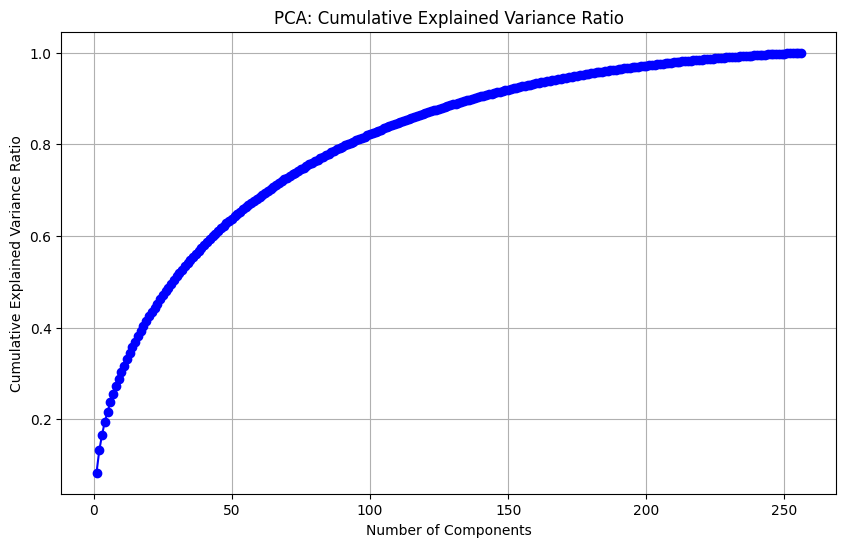

In [ ]:
# Understanding the variance collected by principal componenets
# We will take the elbow value
from sklearn.decomposition import PCA

#X = lbp_df.drop(['Class'], axis=1)
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
# Training on the PCA
# Reduce dimensions using PCA
pca = PCA(n_components=24)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X)

In [ ]:
# Again convertion to the dataframes
Xd = pd.DataFrame(X_train_pca)
Yd = pd.DataFrame(y)

## Training


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Splitting Data
X = horizontal_df.drop('Class', axis=1)  # Features
y = horizontal_df['Class']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Training Logistic Regression
# Initialize Logistic Regression model
model = RandomForestClassifier(n_estimators=400, max_depth=12)

# Train the model on the training data
model.fit(X_train, y_train)

# Step 3: Evaluating Performance
# Predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
outer_results_f1 = list()
for (i,(train_index, test_index)) in enumerate(cv_outer.split(X1,y1)):
    # split data
    X_train_outer, X_test_outer = X1.iloc[train_index], X1.iloc[test_index]
    y_train_outer, y_test_outer = y1.iloc[train_index], y1.iloc[test_index]

    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = LogisticRegression()
    # define search space
    space = dict()
    space['penalty'] = ['l1','l2','elasticnet']
    space['C'] = [0.02,0.04,0.05, 0.07, 0.09]

    # define search
    search = GridSearchCV(model, space, scoring='f1_macro', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train_outer, y_train_outer)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test_outer)
    # evaluate the model
    acc = accuracy_score(y_test_outer, yhat)
    acc_f1=f1_score(y_test_outer, yhat, average='macro')
    # store the result
    outer_results.append(acc)
    outer_results_f1.append(acc_f1)

    # report progress
    print('>acc=%.3f, F1_macro=%.f est=%.3f, cfg=%s' % (acc, acc_f1, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))
print('F1_macro: %.3f (%.3f)' % (np.mean(outer_results_f1), np.std(outer_results_f1)))